# Using Keras to Look at Salt Data

# Introduction

Image segmentation is a key task in Machine Learning and Computer Vision. Variations on Convolutional Neural Nets (CNNs) are used to accomplish this task. An example of such an image segmentation task can be seen in the TGS Salt Identification challenge hosted on Kaggle lasy year. The goal of the challenge is, given a seismic image of the Earth’s surface, to predict where salt bodies occur. This practice is key in the oil industry, as oil typically lies underneath bodies of salt. 

This tutorial will introduce you to the Keras package, an extension of TensorFlow. Keras has built in functions for many differnt types of layers, which allow you to construct complex neural networks in relatively few lines of code. Without the use of Keras or other similar packages, the code in this tutorial would be much longer and harder to debug. 

In this tutorial, we will preprocess the data, explain the purpose each Keras layer has in the network, and construct a variation of the CNN called a U-NET on the TGS Salt data.

# Importing Libraries

First, let's import all of the relevant packages in this tutorial. If any of the packages are not installed in your system, use 

!pip install package_name

before proceding.
Note, you can just import keras and skimage, but in our case we only need these functions.

In [25]:
import os
import numpy as np

import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

#for preprocessing
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize


from keras.layers import Input, Activation, Dropout, BatchNormalization
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import array_to_img, img_to_array, load_img

Let's continue by discussing the data.

# The Data

In order to reduce training time of our network, we will only be using the train.zip folder from the challenge (https://www.kaggle.com/c/tgs-salt-identification-challenge/data). After downloading train.zip, please relocate the “images” and “masks” folders to a convenient location. 

We will read the data in, resize it, and convert it into a 3D array of type double.

The os.walk function allows us to traverse the folders by image name.

In [6]:
ids = next(os.walk("images"))[2]

We will convert the images, originally of size 101 by 101, to 128 by 128 for easier transitions between each convolution (discussed in more detail in a later section). Then we will convert the images to doubles, and regularize the image. X, the predictor, represents the images, and Y, the response, represents the masks.

In [12]:
im_size = 128
X = np.zeros((len(ids), im_size, im_size, 1), dtype=np.float32)
Y = np.zeros((len(ids), im_size, im_size, 1), dtype=np.float32)

n = 0
for curr in ids:

    img = load_img("images/"+curr, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), preserve_range = True, mode = "constant")

    mask = img_to_array(load_img("masks/"+curr, grayscale=True))
    mask = resize(mask, (128, 128, 1), preserve_range = True, mode = "constant")

    X[n] = x_img/255.0
    Y[n] = mask/255.0
    n += 1

Now that we have our predictors and responses, we can now use the train_test_split function to segment out a validation set from our data. In our case, we are randomly setting aside 10% of the data to be our validation set, and we set a random state in order to get the same result each time we run the function.

In [11]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=1)

Let's vizualize one of the image-mask pairs in our training set.

Text(0.5, 1.0, 'Salt Mask')

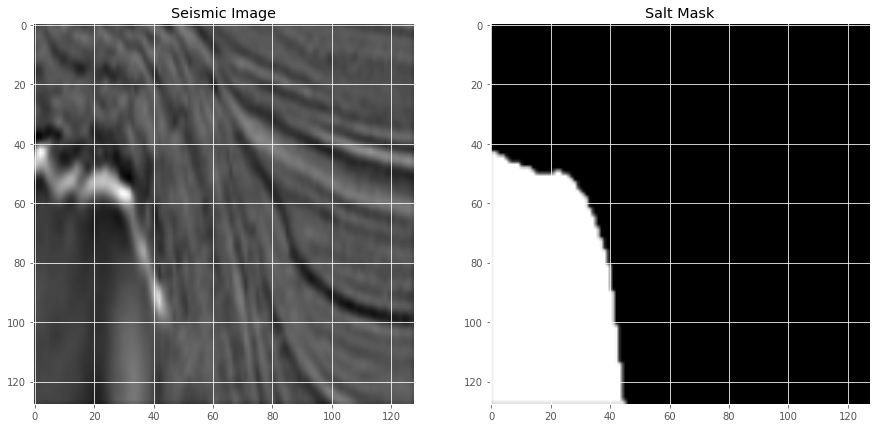

In [99]:
i = 3 #handpicked image with lots of salt in the mask
border = 3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1.imshow(X_train[i, ..., 0], cmap = 'gray', interpolation = 'bilinear')
ax1.set_title('Seismic Image')

ax2.imshow(Y_train[i].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt Mask')

The left image is the input. Note that the white border represents where the salt body should be according to the mask and is not reflected in the input for the training data. The right image is the desired result, where black means no salt, and white means there is salt.

Now that our data is processed, let's move forward with an overview on a subset of Keras features that will help us toward building our final model. (Keras has so many amazing features!)

# Keras and CNN/U-net Introduction

CNN, in its most basic form, takes an input image and performs convolutions on the image in order to break the image down into many different features (i.e. vertical segments, angled segments, etc). After a set number of convolutions determined by the user, the network then works to predict what class that image may belong to. One aspect that the CNN struggles in, however, is image segmentation (classifying different aspects of an input as opposed to classifying the input as a whole). Thus, we utilize an extension of the CNN called the U-net. The core of U-net is to down-sample the input using convolutions into a long list of small features (much like a conventional CNN), then taking this list of features and up-sampling using deconvolutions to reconstruct an output with a shape similar to the input. An intermediate step of the U-net is to concatenate the first down-sampling layer with the last, the second down-sample with the second to last up-sample, etc. This concatenation step helps the network determine where in the network a certain feature appears.

An image of the general architecture of the U-net is as follows (taken from https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/):
![](unet.png)

For further information on the U-net, please visit https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/. This website links to the creators of the network architecture. Their application is in cell segmentation, but may be helpful for understanding. 

Additionally, all of the available features in Keras can be found here: https://keras.io/

Let's proceed with a brief explanation on the layers that we will need in the next section.

## Conv2D

This function is the core of the downsampling portion of the U-net. Conv2D performs a series of convolutions, which are sliding windows of matrix multiplications of size specified by the user using the argument kernel_size. What this function hopes to achieve is to extract features from the input image. The weights of all of these windows is what the network works to train. The great part about Keras is that gradients and back propogation are built into this function, and are kept track of in the backend, so the user does not have to concern themselves with a very tedious part of machine learning.

For a more detailed explanation of convolutions as well as a more detailed introduction to CNNs, please visit https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

## BatchNormalization, MaxPool, and Dropout

We use batch normalization in order to normalize the weights of a current layer. This is a countermeasure agaisnt overfitting. 

For more details on Batch Normalization, please visit: https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c.

Max pooling is a technique where, given a matrix, we take the max of a sliding window. For example, given the matrix

A = [[1,2,3,4],
     [5,6,7,8],     
     [9,10,11,12],     
     [13,14,15,16]],
running Max Pool with a 2 by 2 window would return [[6,8],[14,16]].
This, again, is a countermeasure against overfitting.

Dropout is where random weights in our network will be dropped in each update. This means that in each iteration, a specified number of weights in the neural network will not be updated. This simulates the effect of training multiple networks of varying architectures in parallel.
For a more in depth analysis on Dropout in neural networks, please vist: https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/.

## Activation

In our network in the next section, we use something called an activation function. The intralayer activation function of choice is ReLU, which takes on the value $x$ for $x \geq 0$, and 0 for $x < 0$. The final layer is passed through the sigmoid activation function, which maps the output to a probability between 0 and 1.

We use activation functions in machine learning because convolutions and deconvolutions both involve matrix multiplications - a linear operation. However, in the real world, not all relationships can be mapped using a linear operation. Activations help to map these non-linear operations. 

For more details on activations, please visit: https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0.

## Conv2DTranspose

This function is the core of what we use to up-sample. In essence, this function is the reverse of Conv2D. Given a smaller input, the function finds weights that would yield a larger output.

For an incredibly detailed explanation of deconvolution, please visit: https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0 

Let's combine these functions and build our very own architecture!

# U-Net Model

Below is a simpler version of the U-net model seen in the previous section with fewer intermediate layers. In the down sampling phase of our model, we perform a convolution with a window size of 3 by 3. This is followed by normalizing the weights, passing the weights through the ReLU activation function, and performing a max pool with dropout. In the up-sampling phase of our model, we perform a repeated deconvolution, as well as a concatenation with the corresponding down sampling layer, and a convolution to further sharpen desired features. Finally, the resulting filters are passed through a Sigmoid function in order to determine individual probabilities of salt for each point in the 128 by 128 input.

In [55]:
def conv2d_helper(input_tensor, n_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    x = Conv2D(filters = n_filters, kernel_size = (3,3),\
              padding = 'same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_model(input, n_filters = 16, dropout = 0.05):
    """Function to define the UNET Model"""
    # Downsample
    c1 = conv2d_helper(input, n_filters * 1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_helper(p1, n_filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_helper(p2, n_filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_helper(p3, n_filters = n_filters * 8)
    #upsample and concateneation
    u5 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c4)
    u5 = concatenate([u5, c3])
    u5 = Dropout(dropout)(u5)
    c5 = conv2d_helper(u5, n_filters * 4)
    
    u6 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c2])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_helper(u6, n_filters * 2)
    
    u7 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c1])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_helper(u7, n_filters * 1)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = Model(inputs=[input], outputs=[outputs])
    return model

We now can call our model building function. In order to compile the model, we run model.compile(). Notice that the loss function is set to binary cross entropy, also known as log loss, which measures the performance of a classification model with two classes (outputs are probabilities between 0 and 1, in our case, 0 is no salt, 1 is has salt).  Furthermore, we want to display a built-in accuracy, as this value is more intuitive than the value given by log loss. Finally, we utilize something know as the Adams optimizer, which updates the learning rate of our network, as opposed to keeping the learning rate constant as in standard stochastic gradient descent.

In [56]:
input_img = Input((im_size, im_size, 1))
model = get_model(input_img, n_filters=16, dropout=0.05)
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer = Adam())

Let's see the inner workings of the model by printing the model summary.

In [95]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 128, 128, 16) 64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 128, 128, 16) 0           batch_normalization_41[0][0]     
____________________________________________________________________________________________

We see that the model downsamples into 128 filters of size 16 x 16, and then reconstructs a single output of size 128 by 128. Earlier, our resize to 128 was so that these numbers would be much nuicer than if we had continued with size 101. 

In order to train our network, we use the function model.fit(). Note that 1 epoch is equivalent to iterating through the training data 1 time. 

When training the network, we will utilize a useful feature of Keras: callbacks. The list of callbacks that we are using are ReduceLRonPlateau, ModelCheckpoint, and EarlyStopping. ReduceLRonPlateau reduces the learning rate if the validation accuracy has not improved after "patience" number of epochs. Model checkpoint saves the weights of the model with the lowest validation loss. Lastly, EarlyStopping stops training if the network has not improved its validation loss within "patience" number of epochs. 

Another great aspect of keras is that when training, the output is helps track progress. The output of model.fit allows us to see which epoch the network is currently training, the time taken per epoch, as well as what the train and validation loss are at that point. 

This code portion may take a significant amount of time to run, depending on your hardware resources. If you do not have the time to train the network, the trained weights are provided in the zip file, and you can skip this code block.

In [58]:
cbs = [
    ReduceLROnPlateau(factor=0.1, patience=5, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_weights_only=True, save_best_only=True),
    EarlyStopping(patience=10, verbose=1)
]
results = model.fit(X_train, Y_train, epochs=50, callbacks=cbs,\
                    validation_data=(X_valid, Y_valid))

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 236s 74ms/step - loss: 0.4716 - accuracy: 0.7793 - val_loss: 2.5883 - val_accuracy: 0.2457

Epoch 00001: val_loss improved from inf to 2.58828, saving model to model-tgs-salt.h5
Epoch 2/50
3200/3200 [==============================] - 233s 73ms/step - loss: 0.3551 - accuracy: 0.8548 - val_loss: 2.6227 - val_accuracy: 0.2460

Epoch 00002: val_loss did not improve from 2.58828
Epoch 3/50
3200/3200 [==============================] - 224s 70ms/step - loss: 0.3195 - accuracy: 0.8669 - val_loss: 3.7976 - val_accuracy: 0.2475

Epoch 00003: val_loss did not improve from 2.58828
Epoch 4/50
3200/3200 [==============================] - 233s 73ms/step - loss: 0.2977 - accuracy: 0.8757 - val_loss: 1.1892 - val_accuracy: 0.4419

Epoch 00004: val_loss improved from 2.58828 to 1.18922, saving model to model-tgs-salt.h5
Epoch 5/50
3200/3200 [==============================] - 231s 72ms/step - loss: 0.29

We see that the training stopped early at 32 epochs. The best validation loss achieved by our network was 0.2065, with validation accuracy 0.9078. This occured on epoch 22. The training loss and accuracy at this point were  0.1993 and 0.9135, respectively.

# Results

Let's visualize how we did! Below is code that returns three images: the input, the desired output, and the prediction. Since the network will return values between 0 and 1 for each element in the 128 by 128 output, we threshold and say that output values > 0.5 will be labeled as has salt, and anything else will be labeled as no salt. First, lets load the trained weights into a model. This code should take a couple of minutes.

In [65]:
model.load_weights("model.h5")
train_preds = model.predict(X_train)
val_preds = model.predict(X_valid)
#threshold the predictions
b_train_preds = (train_preds > 0.5).astype(np.int8)
b_val_preds = (val_preds > 0.5).astype(np.int8)

800/800 [==============================] - 15s 19ms/step


Text(0.5, 1.0, 'Salt Predicted')

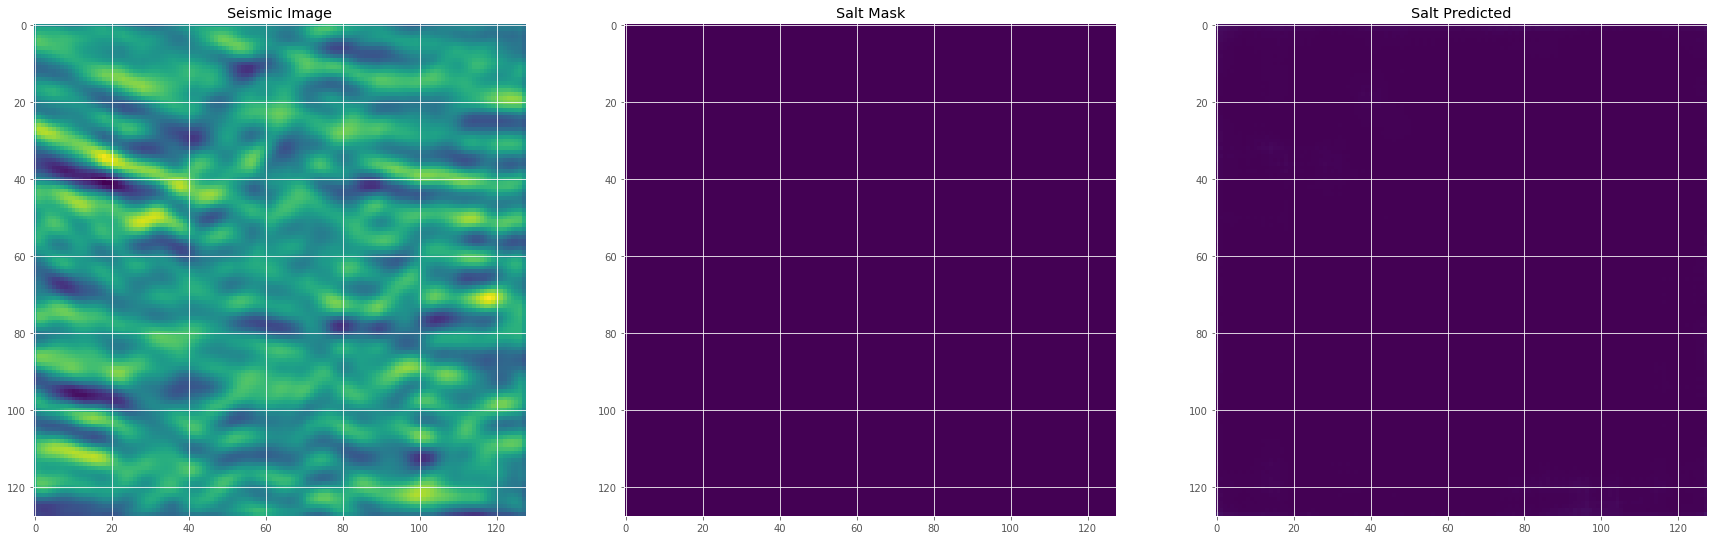

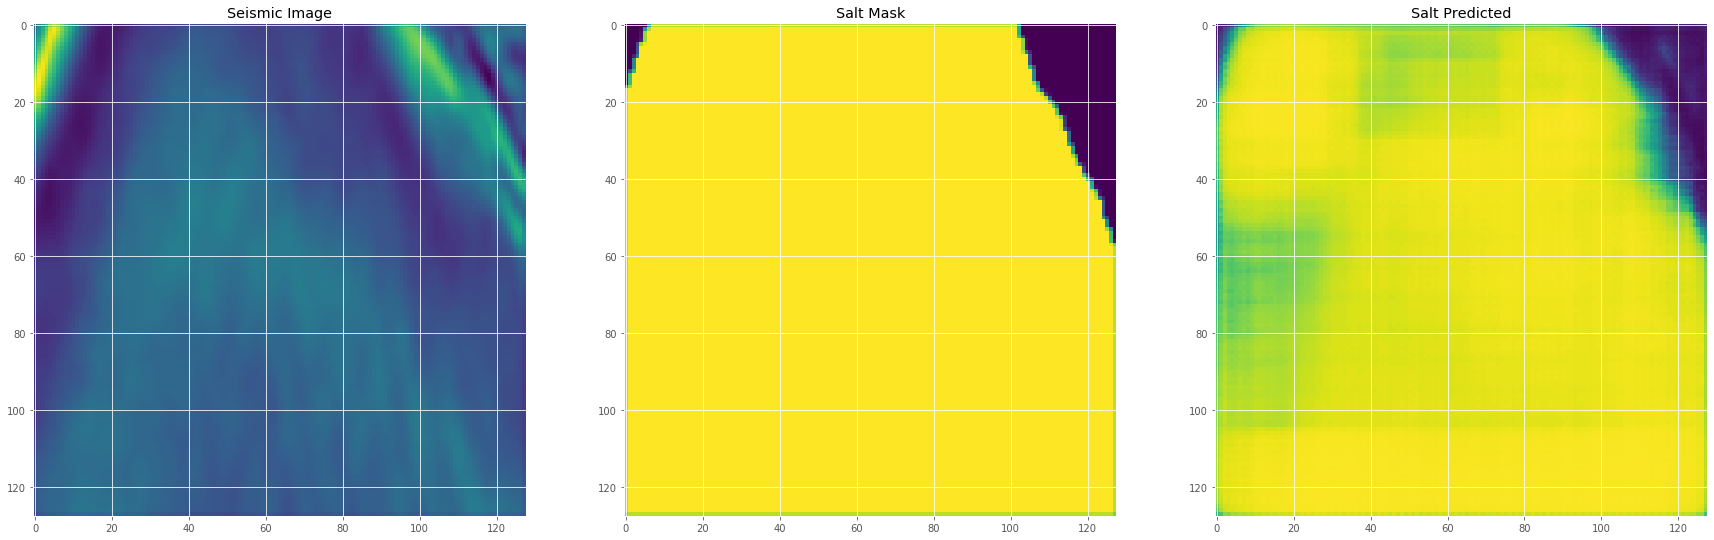

In [97]:
#first image
i = 2
has_salt = Y_train[i].max() > 0

fig, ax = plt.subplots(1, 3, figsize=(30, 20))
ax[0].imshow(X_train[i, ..., 0])
ax[0].set_title('Seismic Image')

ax[1].imshow(Y_train[i].squeeze())
ax[1].set_title('Salt Mask')
    
ax[2].imshow(train_preds[i].squeeze(), vmin=0, vmax=1)
ax[2].set_title('Salt Predicted')

#second image
i = 50

fig, ax = plt.subplots(1, 3, figsize=(30, 20))
ax[0].imshow(X_train[i, ..., 0])
ax[0].set_title('Seismic Image')

ax[1].imshow(Y_train[i].squeeze())
ax[1].set_title('Salt Mask')
    
ax[2].imshow(train_preds[i].squeeze(), vmin=0, vmax=1)
ax[2].set_title('Salt Predicted')

The network appears to do a solid job of predicting those with no salt, and struggles a little bit on the salt boundary. However, these diagrams are on the training set; let’s see how we did on the validation set.

Text(0.5, 1.0, 'Salt Predicted')

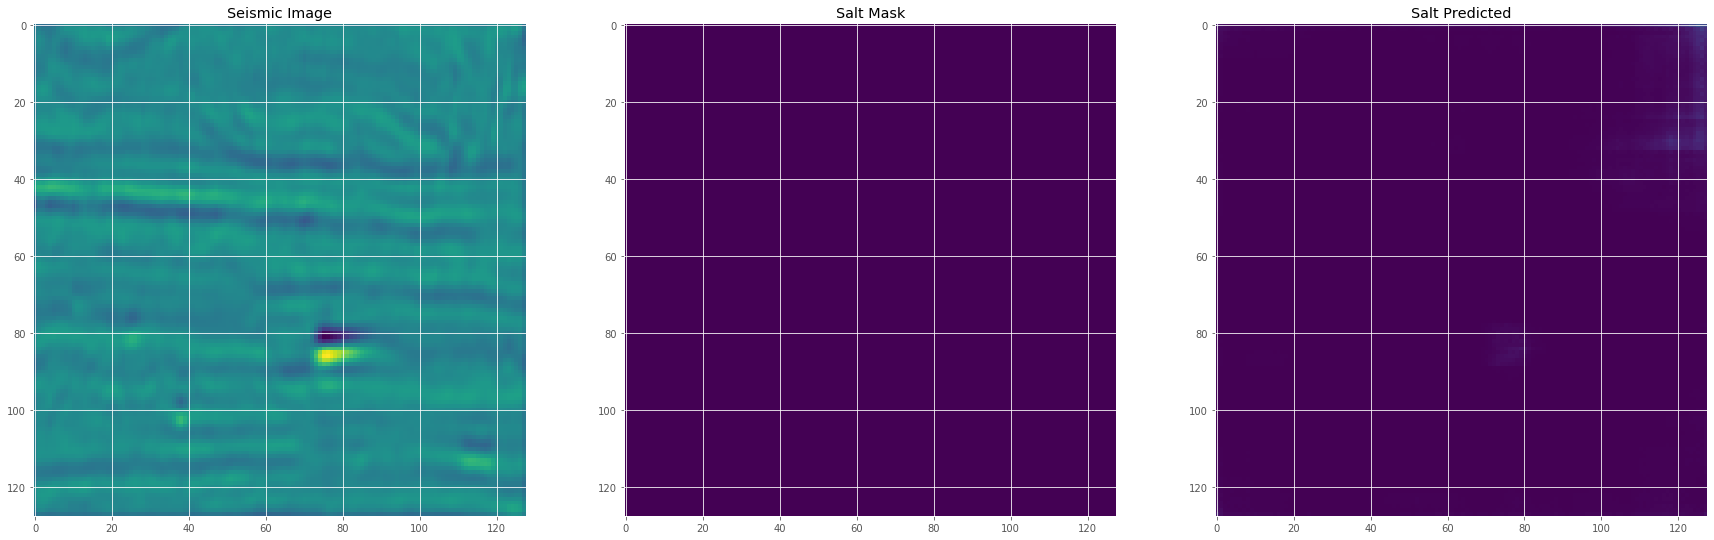

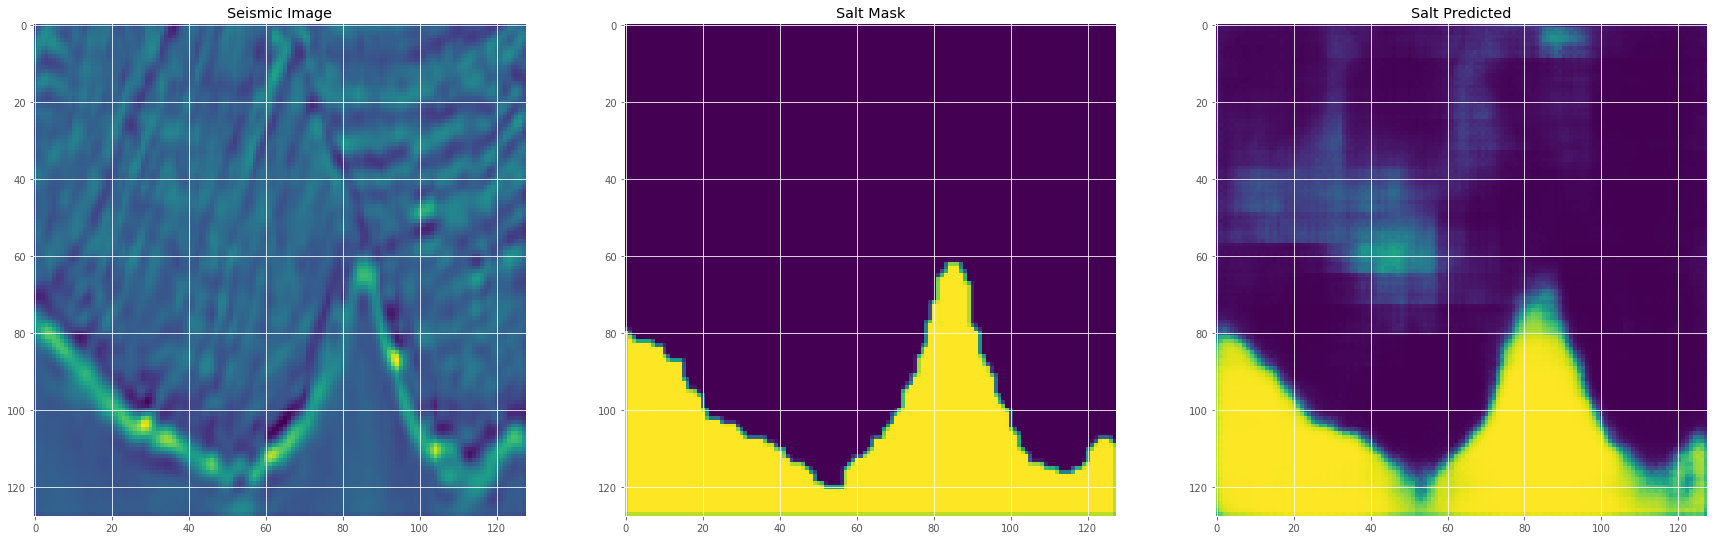

In [98]:
i = 10
has_salt = Y_valid[i].max() > 0

fig, ax = plt.subplots(1, 3, figsize=(30, 20))
ax[0].imshow(X_valid[i, ..., 0])
ax[0].set_title('Seismic Image')

ax[1].imshow(Y_valid[i].squeeze())
ax[1].set_title('Salt Mask')
    
ax[2].imshow(val_preds[i].squeeze(), vmin=0, vmax=1)
ax[2].set_title('Salt Predicted')

i = 20

fig, ax = plt.subplots(1, 3, figsize=(30, 20))
ax[0].imshow(X_valid[i, ..., 0])
ax[0].set_title('Seismic Image')

ax[1].imshow(Y_valid[i].squeeze())
ax[1].set_title('Salt Mask')
    
ax[2].imshow(val_preds[i].squeeze(), vmin=0, vmax=1)
ax[2].set_title('Salt Predicted')

Again, the network does a decent job at detecting no salt, but there is so noise when salt is present.

# Conclusion

I decided to do this topic because it pertained to my internship last summer. This tutorial is a simpler version of my project, but through my project, I learned of the existance of Keras. 
Although if the Kaggle challenge was still running, this tutorial would not be anywhere near the top of the leaderboard, I really wanted to share this powerful tool, and I'm sure it will continue to amaze me, and now hopefully you, in the future. 